In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from utils import plot_learning_curve

In [2]:
class TwoInputsNet(nn.Module):
    # ****
    # tengo que revisar mejor sobre los channels y toda esta locura porque hay algo raro. sobretodo en la parte de los filtros.
    
    # revisa que todas tus dimensiones esten correctas.
    # ****
    def __init__(self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions):
        super(TwoInputsNet, self).__init__()
        self.conv_open = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_high = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_low = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_close = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_volume = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.fc_state = nn.Linear(2, 2)
        
        self.fc1 = nn.Linear(input_dims, fc1_dims) #input dims is the sum of all outputs of the conv layers.
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        # Open High Low Close Volume in that order (also for the numpy array)
        # input6 son dos nodos de input para saber si el agente ha comprado/vendido y en cuanto.
    def forward(self, input1, input2, input3, input4, input5, input6):
        c1 = self.conv_open(input1.unsqueeze(dim = 1))
        c2 = self.conv_high(input2.unsqueeze(dim = 1))
        c3 = self.conv_low(input3.unsqueeze(dim = 1))
        c4 = self.conv_close(input4.unsqueeze(dim = 1))
        c5 = self.conv_volume(input5.unsqueeze(dim = 1))
        f1 = self.fc_state(input6)
        
        # now we can reshape to 2D and concat them
        combined = T.cat((c1.view(c1.size(0), -1), 
                          c2.view(c2.size(0), -1),
                          c3.view(c3.size(0), -1),
                          c4.view(c4.size(0), -1),
                          c5.view(c5.size(0), -1),
                          f1.view(f1.size(0), -1)), dim=1)
        
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions
    
class Agent():
    # ***hyperparameters
    def __init__(self, gamma, epsilon, lr, input_dims1, input_dims2, batch_size, n_actions,
                max_mem_size = 100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        # self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        # (self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions)
        # en otras parabras (learning rate, cantidad de filtros de entrada, cantidad de filtros de salida, tamaño del kernel)
        #  ***hyperparameters
        self.Q_eval = TwoInputsNet(self.lr, 1, 4, 3, 562, 128, 128, n_actions)
        #                                             ^
        # tengo que encontrar una forma para hacer que se haga el tamaño del fc layer automaticamente
        
        # ***
        # tengo que reviar si el replay memory esta funcionando correctamente, sobre todo el *input_dims
        # as of now I checked the state_memory shape (10000, 30, 5) and it looks correct
        # ***
        self.state_memory = np.zeros((self.mem_size, *input_dims1), dtype = np.float32)
        self.state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims1), dtype=np.float32)
        self.new_state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state[0]
        self.state_memory2[index] = state[1]
        self.new_state_memory[index] = state_[0]
        self.new_state_memory2[index] = state_[1]
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # aqui tuve que separar la observacion en las 2 partes y transformarlas a pytorch tensor. 
            # no se si es lo mejor, pero sirve asi que...
            
            state = T.tensor([observation[0]]).to(self.Q_eval.device)
            state2 = T.tensor([observation[1]]).to(self.Q_eval.device)
#             print(state)
            actions = self.Q_eval.forward(state[:,:,0], 
                                          state[:,:,1], 
                                          state[:,:,2], 
                                          state[:,:,3], 
                                          state[:,:,4],
                                          state2[:])
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        state_batch2 = T.tensor(self.state_memory2[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        new_state_batch2 = T.tensor(self.new_state_memory2[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch[:,:,0], 
                                     state_batch[:,:,1], 
                                     state_batch[:,:,2], 
                                     state_batch[:,:,3], 
                                     state_batch[:,:,4],
                                     state_batch2[:])[batch_index, action_batch]
    
        q_next = self.Q_eval.forward(new_state_batch[:,:,0], 
                                     new_state_batch[:,:,1], 
                                     new_state_batch[:,:,2], 
                                     new_state_batch[:,:,3], 
                                     new_state_batch[:,:,4],
                                     new_state_batch2[:])
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                        else self.eps_min


In [3]:
# ***
# tienes que refactorizar esta vaina porque no se sabe si verdaderamente sirve esta porqueria y ta escrito bien feo
# tambien hay que agregar cosas en el env para que sea mas realistico (como el tax cuando compras/vendes)
# hay una vaina rara con las dimensiones de la observacion asi que tendras que revisar eso tambien para ver si sirve bien.
# ***


class environment:
    # you pass the historical data as a numpy array to the init.
    # first you have to save the price at the time of the action.  
    # 
    
    def __init__(self, historical_data, observation_size):
        self.historical_data = historical_data
        
        self.leverage = 10
        self.action_history = []
        self.buy_sell = None # variable to know if the first position is either a buy or a sell; buy = 0, sell = 1
        self.current_price = None
        self.initial_price = None
        self.reward = 0
        self.timesteps = 0
        self.observation = None
        self.info = None # unused as of now
        self.done = None
        self.current_position = None
        self.start_position = None
        self.observation_size = observation_size
        self.first_run = True

        self.buy_sell_price_obs = np.array([0, 0], dtype = np.float32)
        self.full_observation = []
        

        
    def step(self, action):
        # get action and return what the agent needs. take into account the penalty for instantly buying and selling.
        # as of now I plan to do it as an episodic task, I will have to check this approach as it could bring problems later.
        # episode ends when agent gets a return(ie, buys then sells or sells then buys)
        # reward is the profit that the agent gets at the end of the episode
        # info might be how many timesteps the episode lasted
        # think about implementing variable reward or reward decaying to get certain behaviours early on.
        # maybe we should penalize consecutive buys and consecutive sells?
        # maybe the agent should know if he's bought or sold previuosly in this episode? (almost definitely) (encoding/0,1,2)
        # the agent should also know the price that he bought at. (as an input to the neural network) 
        # now that I think about it, the reward cant be just profit, it has to be the ratio of investment to return so that the
        # reward remains constant.
        self.first_run = False
        self.reward = 0
        
        
        self.timesteps = self.timesteps + 1
        self.current_position = self.start_position + self.timesteps 
        self.observation = self.historical_data[self.current_position - self.observation_size : self.current_position]
        self.current_price = self.observation[self.observation_size - 1, 3] #get current price based on current position
        
        
        if action == 0:
            # you dont actually have to do much
            self.done = False
            self.reward = 0
            
        if action == 1:
            self.done = False
            self.reward = 0
            
            #first buy
            if self.buy_sell == None:
                self.buy_sell = 0
                self.buy_sell_price_obs[0] = 1
                self.buy_sell_price_obs[1] = self.current_price
            
            # buy buy
            if self.buy_sell == 0:
                self.action_history.append(self.initial_price)
            # sell buy    
            if self.buy_sell == 1:
                #get all prices and get the total profit
                # remember that the calculation is done in the opposite side. so this calculation is for selling then buying
                # and the return is positive when the current price is lower than the initial price
                for price in self.action_history:
                    self.reward = self.reward + (price * self.leverage) - (self.current_price * self.leverage)
                
                self.done = True
                print("The episode ran for {} timesteps.".format(self.timesteps))
                self.observation = self.reset()
                
            
        if action == 2:
            self.done = False
            self.reward = 0
            
            #first sell
            if self.buy_sell == None:
                self.buy_sell = 1
                self.buy_sell_price_obs[0] = 2
                self.buy_sell_price_obs[1] = self.current_price
                
            # sell sell
            if self.buy_sell == 1:
                self.action_history.append(self.initial_price)
            # buy sell
            if self.buy_sell == 0:
                # get all prices and get total profit
                # remember that the calculation is done in the opposite side. so this calculation is for buying then selling
                # and the return is positive when the current price is higher than the initial price
                for price in self.action_history:
                    self.reward = self.reward - (price * self.leverage) + (self.current_price * self.leverage)
                
                self.done = True
                print("The episode ran for {} timesteps.".format(self.timesteps))
                self.observation = self.reset()
                
            
        # full_observations is a [2] list which has the price action observation [observation_size, 5]
        # and buy_sell_price_obs [2] con la memoria de la accion y el precio al momento de la accion. 
        
        self.observation_full = []
        self.full_observation = [self.observation, self.buy_sell_price_obs]
#         print(self.full_observation)
        return self.full_observation, self.reward, self.done, self.info
    
    def reset(self):
        # get random starting point in historical data and return the first point as an observation.
        # reset all variables used for the episode
        
        # you have to check more thoroughly to determine which variables you dont have to reset
        # this is so that you can return properly on the env.step() function.
        
        self.action_history = []
        self.buy_sell = None # variable to know if the first position is either a buy or a sell; buy = 0, sell = 1
        self.current_price = None
        self.initial_price = None
#         if self.first_run:
#             print("The episode ran for {} timesteps.".format(self.timesteps))
        self.timesteps = 0
        self.observation = None
        self.current_position = None
        self.start_position = None
        self.first_price_action = 0
        
        # test
        self.buy_sell_price_obs = np.array([0, 0], dtype = np.float32)
        self.observation_full = []
        
        
        self.start_position = random.randint(self.observation_size, 45000) # get random number to start
#         print(self.start_position)
        observation = self.historical_data[self.start_position - self.observation_size : self.start_position]
        self.initial_price = observation[self.observation_size - 1, 3]

        if self.first_run:
            self.full_observation = [observation, self.buy_sell_price_obs]
            return self.full_observation
        self.first_run = True
        return observation
        

The episode ran for 5 timesteps.
episode 0 score -0.00 average score -0.00 epsilon 1.00
The episode ran for 5 timesteps.
episode 1 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 5 timesteps.
episode 2 score 0.01 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 3 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 4 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 5 score -0.00 average score 0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 6 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 7 timesteps.
episode 7 score 0.02 average score 0.00 epsilon 1.00
The episode ran for 6 timesteps.
episode 8 score -0.02 average score 0.00 epsilon 1.00
The episode ran for 10 timesteps.
episode 9 score 0.01 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 10 score -0.00 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 11 sco

The episode ran for 10 timesteps.
episode 94 score 0.04 average score -0.00 epsilon 0.83
The episode ran for 4 timesteps.
episode 95 score 0.00 average score -0.00 epsilon 0.83
The episode ran for 6 timesteps.
episode 96 score -0.01 average score -0.00 epsilon 0.83
The episode ran for 6 timesteps.
episode 97 score -0.02 average score -0.00 epsilon 0.83
The episode ran for 3 timesteps.
episode 98 score 0.01 average score -0.00 epsilon 0.82
The episode ran for 2 timesteps.
episode 99 score 0.01 average score -0.00 epsilon 0.82
The episode ran for 4 timesteps.
episode 100 score -0.02 average score -0.00 epsilon 0.82
The episode ran for 6 timesteps.
episode 101 score 0.01 average score -0.00 epsilon 0.82
The episode ran for 4 timesteps.
episode 102 score 0.00 average score -0.00 epsilon 0.82
The episode ran for 9 timesteps.
episode 103 score 0.01 average score -0.00 epsilon 0.81
The episode ran for 5 timesteps.
episode 104 score -0.00 average score -0.00 epsilon 0.81
The episode ran for 2 

episode 188 score -0.00 average score 0.01 epsilon 0.57
The episode ran for 6 timesteps.
episode 189 score 0.01 average score 0.01 epsilon 0.57
The episode ran for 10 timesteps.
episode 190 score -0.00 average score 0.01 epsilon 0.57
The episode ran for 4 timesteps.
episode 191 score 0.01 average score 0.01 epsilon 0.56
The episode ran for 6 timesteps.
episode 192 score 0.01 average score 0.01 epsilon 0.56
The episode ran for 3 timesteps.
episode 193 score -0.00 average score 0.01 epsilon 0.56
The episode ran for 6 timesteps.
episode 194 score -0.00 average score 0.01 epsilon 0.56
The episode ran for 9 timesteps.
episode 195 score -0.01 average score 0.01 epsilon 0.55
The episode ran for 7 timesteps.
episode 196 score -0.00 average score 0.01 epsilon 0.55
The episode ran for 8 timesteps.
episode 197 score 0.01 average score 0.01 epsilon 0.54
The episode ran for 2 timesteps.
episode 198 score 0.01 average score 0.01 epsilon 0.54
The episode ran for 5 timesteps.
episode 199 score -0.00 a

The episode ran for 431 timesteps.
episode 281 score -0.02 average score 0.00 epsilon 0.01
The episode ran for 365 timesteps.
episode 282 score 0.13 average score 0.00 epsilon 0.01
The episode ran for 292 timesteps.
episode 283 score -1.55 average score -0.01 epsilon 0.01
The episode ran for 142 timesteps.
episode 284 score -0.19 average score -0.01 epsilon 0.01
The episode ran for 144 timesteps.
episode 285 score -0.61 average score -0.02 epsilon 0.01
The episode ran for 511 timesteps.
episode 286 score 1.57 average score -0.00 epsilon 0.01
The episode ran for 180 timesteps.
episode 287 score -0.30 average score -0.01 epsilon 0.01
The episode ran for 353 timesteps.
episode 288 score -0.38 average score -0.01 epsilon 0.01
The episode ran for 11 timesteps.
episode 289 score -0.06 average score -0.01 epsilon 0.01
The episode ran for 834 timesteps.
episode 290 score -0.02 average score -0.01 epsilon 0.01
The episode ran for 111 timesteps.
episode 291 score -0.02 average score -0.01 epsilo

The episode ran for 45 timesteps.
episode 373 score 4.17 average score 0.11 epsilon 0.01
The episode ran for 7 timesteps.
episode 374 score -0.01 average score 0.11 epsilon 0.01
The episode ran for 46 timesteps.
episode 375 score 0.37 average score 0.12 epsilon 0.01
The episode ran for 55 timesteps.
episode 376 score -0.26 average score 0.11 epsilon 0.01
The episode ran for 62 timesteps.
episode 377 score -0.70 average score 0.11 epsilon 0.01
The episode ran for 62 timesteps.
episode 378 score -0.91 average score 0.10 epsilon 0.01
The episode ran for 6 timesteps.
episode 379 score 0.13 average score 0.10 epsilon 0.01
The episode ran for 4 timesteps.
episode 380 score 0.00 average score 0.11 epsilon 0.01
The episode ran for 13 timesteps.
episode 381 score 0.01 average score 0.11 epsilon 0.01
The episode ran for 12 timesteps.
episode 382 score -0.00 average score 0.10 epsilon 0.01
The episode ran for 65 timesteps.
episode 383 score 1.03 average score 0.13 epsilon 0.01
The episode ran for

The episode ran for 80 timesteps.
episode 465 score 0.52 average score 0.33 epsilon 0.01
The episode ran for 145 timesteps.
episode 466 score -0.04 average score 0.33 epsilon 0.01
The episode ran for 13 timesteps.
episode 467 score -0.39 average score 0.33 epsilon 0.01
The episode ran for 75 timesteps.
episode 468 score 0.22 average score 0.32 epsilon 0.01
The episode ran for 19 timesteps.
episode 469 score -0.03 average score 0.30 epsilon 0.01
The episode ran for 73 timesteps.
episode 470 score 2.29 average score 0.33 epsilon 0.01
The episode ran for 8 timesteps.
episode 471 score 0.01 average score 0.36 epsilon 0.01
The episode ran for 11 timesteps.
episode 472 score 0.00 average score 0.36 epsilon 0.01
The episode ran for 10 timesteps.
episode 473 score 0.07 average score 0.31 epsilon 0.01
The episode ran for 33 timesteps.
episode 474 score 0.41 average score 0.32 epsilon 0.01
The episode ran for 18 timesteps.
episode 475 score 0.40 average score 0.32 epsilon 0.01
The episode ran fo

The episode ran for 172 timesteps.
episode 556 score 6.83 average score -0.43 epsilon 0.01
The episode ran for 3 timesteps.
episode 557 score -0.01 average score -0.42 epsilon 0.01
The episode ran for 18 timesteps.
episode 558 score -0.36 average score -0.43 epsilon 0.01
The episode ran for 96 timesteps.
episode 559 score 2.83 average score -0.40 epsilon 0.01
The episode ran for 83 timesteps.
episode 560 score 0.18 average score -0.39 epsilon 0.01
The episode ran for 73 timesteps.
episode 561 score 0.44 average score -0.38 epsilon 0.01
The episode ran for 109 timesteps.
episode 562 score 3.99 average score -0.34 epsilon 0.01
The episode ran for 10 timesteps.
episode 563 score 0.03 average score -0.34 epsilon 0.01
The episode ran for 79 timesteps.
episode 564 score 0.65 average score -0.33 epsilon 0.01
The episode ran for 89 timesteps.
episode 565 score 0.33 average score -0.33 epsilon 0.01
The episode ran for 74 timesteps.
episode 566 score -4.61 average score -0.37 epsilon 0.01
The ep

The episode ran for 90 timesteps.
episode 647 score -0.64 average score 0.12 epsilon 0.01
The episode ran for 42 timesteps.
episode 648 score 0.06 average score 0.08 epsilon 0.01
The episode ran for 141 timesteps.
episode 649 score 9.20 average score 0.17 epsilon 0.01
The episode ran for 8 timesteps.
episode 650 score 0.14 average score 0.16 epsilon 0.01
The episode ran for 71 timesteps.
episode 651 score -1.48 average score 0.15 epsilon 0.01
The episode ran for 68 timesteps.
episode 652 score 4.59 average score 0.20 epsilon 0.01
The episode ran for 16 timesteps.
episode 653 score -0.71 average score 0.29 epsilon 0.01
The episode ran for 29 timesteps.
episode 654 score 0.01 average score 0.28 epsilon 0.01
The episode ran for 65 timesteps.
episode 655 score -1.28 average score 0.28 epsilon 0.01
The episode ran for 12 timesteps.
episode 656 score 0.00 average score 0.21 epsilon 0.01
The episode ran for 24 timesteps.
episode 657 score -0.00 average score 0.21 epsilon 0.01
The episode ran 

The episode ran for 94 timesteps.
episode 738 score -1.01 average score -0.27 epsilon 0.01
The episode ran for 29 timesteps.
episode 739 score -0.09 average score -0.27 epsilon 0.01
The episode ran for 9 timesteps.
episode 740 score -0.01 average score -0.27 epsilon 0.01
The episode ran for 29 timesteps.
episode 741 score 0.11 average score -0.27 epsilon 0.01
The episode ran for 119 timesteps.
episode 742 score 6.96 average score -0.19 epsilon 0.01
The episode ran for 122 timesteps.
episode 743 score -6.15 average score -0.26 epsilon 0.01
The episode ran for 121 timesteps.
episode 744 score 0.40 average score -0.25 epsilon 0.01
The episode ran for 55 timesteps.
episode 745 score -0.53 average score -0.26 epsilon 0.01
The episode ran for 12 timesteps.
episode 746 score -0.05 average score -0.31 epsilon 0.01
The episode ran for 56 timesteps.
episode 747 score -0.34 average score -0.31 epsilon 0.01
The episode ran for 52 timesteps.
episode 748 score 0.36 average score -0.31 epsilon 0.01
T

The episode ran for 34 timesteps.
episode 829 score 0.20 average score 0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 830 score -0.02 average score 0.04 epsilon 0.01
The episode ran for 20 timesteps.
episode 831 score -0.05 average score 0.04 epsilon 0.01
The episode ran for 77 timesteps.
episode 832 score -0.38 average score 0.03 epsilon 0.01
The episode ran for 21 timesteps.
episode 833 score 0.07 average score 0.14 epsilon 0.01
The episode ran for 16 timesteps.
episode 834 score -0.13 average score 0.16 epsilon 0.01
The episode ran for 31 timesteps.
episode 835 score -0.65 average score 0.15 epsilon 0.01
The episode ran for 19 timesteps.
episode 836 score -0.11 average score 0.15 epsilon 0.01
The episode ran for 37 timesteps.
episode 837 score -0.36 average score 0.14 epsilon 0.01
The episode ran for 42 timesteps.
episode 838 score -1.24 average score 0.14 epsilon 0.01
The episode ran for 6 timesteps.
episode 839 score -0.01 average score 0.14 epsilon 0.01
The episode ra

The episode ran for 27 timesteps.
episode 921 score 0.60 average score 0.11 epsilon 0.01
The episode ran for 34 timesteps.
episode 922 score -0.18 average score 0.11 epsilon 0.01
The episode ran for 107 timesteps.
episode 923 score 0.85 average score 0.13 epsilon 0.01
The episode ran for 17 timesteps.
episode 924 score 0.10 average score 0.13 epsilon 0.01
The episode ran for 21 timesteps.
episode 925 score 0.63 average score 0.10 epsilon 0.01
The episode ran for 42 timesteps.
episode 926 score -1.09 average score 0.07 epsilon 0.01
The episode ran for 15 timesteps.
episode 927 score -0.04 average score 0.08 epsilon 0.01
The episode ran for 61 timesteps.
episode 928 score 0.60 average score 0.08 epsilon 0.01
The episode ran for 48 timesteps.
episode 929 score 2.13 average score 0.10 epsilon 0.01
The episode ran for 79 timesteps.
episode 930 score -0.27 average score 0.10 epsilon 0.01
The episode ran for 86 timesteps.
episode 931 score -1.00 average score 0.09 epsilon 0.01
The episode ran

The episode ran for 64 timesteps.
episode 1012 score 4.19 average score -0.06 epsilon 0.01
The episode ran for 103 timesteps.
episode 1013 score -0.46 average score -0.07 epsilon 0.01
The episode ran for 33 timesteps.
episode 1014 score -0.97 average score -0.07 epsilon 0.01
The episode ran for 184 timesteps.
episode 1015 score 2.64 average score -0.05 epsilon 0.01
The episode ran for 38 timesteps.
episode 1016 score 0.41 average score -0.05 epsilon 0.01
The episode ran for 114 timesteps.
episode 1017 score 1.79 average score -0.04 epsilon 0.01
The episode ran for 47 timesteps.
episode 1018 score 0.82 average score -0.03 epsilon 0.01
The episode ran for 124 timesteps.
episode 1019 score 0.28 average score -0.01 epsilon 0.01
The episode ran for 47 timesteps.
episode 1020 score 1.05 average score -0.00 epsilon 0.01
The episode ran for 100 timesteps.
episode 1021 score 1.59 average score 0.01 epsilon 0.01
The episode ran for 11 timesteps.
episode 1022 score 0.08 average score 0.01 epsilon

The episode ran for 49 timesteps.
episode 1102 score -0.74 average score -0.15 epsilon 0.01
The episode ran for 83 timesteps.
episode 1103 score -1.21 average score -0.16 epsilon 0.01
The episode ran for 15 timesteps.
episode 1104 score 0.12 average score -0.16 epsilon 0.01
The episode ran for 4 timesteps.
episode 1105 score -0.00 average score -0.16 epsilon 0.01
The episode ran for 151 timesteps.
episode 1106 score 7.92 average score -0.08 epsilon 0.01
The episode ran for 43 timesteps.
episode 1107 score -0.60 average score -0.09 epsilon 0.01
The episode ran for 7 timesteps.
episode 1108 score -0.03 average score 0.02 epsilon 0.01
The episode ran for 40 timesteps.
episode 1109 score -0.40 average score 0.01 epsilon 0.01
The episode ran for 86 timesteps.
episode 1110 score 4.93 average score 0.07 epsilon 0.01
The episode ran for 23 timesteps.
episode 1111 score 0.07 average score 0.06 epsilon 0.01
The episode ran for 148 timesteps.
episode 1112 score 6.29 average score 0.09 epsilon 0.0

The episode ran for 43 timesteps.
episode 1192 score -2.12 average score 0.01 epsilon 0.01
The episode ran for 39 timesteps.
episode 1193 score -0.14 average score 0.01 epsilon 0.01
The episode ran for 51 timesteps.
episode 1194 score 1.07 average score 0.03 epsilon 0.01
The episode ran for 10 timesteps.
episode 1195 score 0.06 average score 0.03 epsilon 0.01
The episode ran for 88 timesteps.
episode 1196 score 0.89 average score 0.05 epsilon 0.01
The episode ran for 11 timesteps.
episode 1197 score 0.02 average score 0.07 epsilon 0.01
The episode ran for 96 timesteps.
episode 1198 score 0.39 average score 0.11 epsilon 0.01
The episode ran for 20 timesteps.
episode 1199 score 0.10 average score 0.11 epsilon 0.01
The episode ran for 12 timesteps.
episode 1200 score -0.24 average score 0.11 epsilon 0.01
The episode ran for 37 timesteps.
episode 1201 score -0.15 average score 0.05 epsilon 0.01
The episode ran for 104 timesteps.
episode 1202 score 4.18 average score 0.10 epsilon 0.01
The e

The episode ran for 83 timesteps.
episode 1283 score 5.58 average score 0.20 epsilon 0.01
The episode ran for 83 timesteps.
episode 1284 score -1.12 average score 0.17 epsilon 0.01
The episode ran for 5 timesteps.
episode 1285 score 0.02 average score 0.18 epsilon 0.01
The episode ran for 84 timesteps.
episode 1286 score -0.54 average score 0.17 epsilon 0.01
The episode ran for 6 timesteps.
episode 1287 score 0.01 average score 0.18 epsilon 0.01
The episode ran for 60 timesteps.
episode 1288 score 0.57 average score 0.18 epsilon 0.01
The episode ran for 43 timesteps.
episode 1289 score -3.34 average score 0.14 epsilon 0.01
The episode ran for 21 timesteps.
episode 1290 score 0.02 average score 0.14 epsilon 0.01
The episode ran for 2 timesteps.
episode 1291 score -0.01 average score 0.11 epsilon 0.01
The episode ran for 104 timesteps.
episode 1292 score 0.87 average score 0.14 epsilon 0.01
The episode ran for 19 timesteps.
episode 1293 score 0.08 average score 0.14 epsilon 0.01
The epis

The episode ran for 28 timesteps.
episode 1373 score -0.02 average score -0.11 epsilon 0.01
The episode ran for 58 timesteps.
episode 1374 score -0.01 average score -0.14 epsilon 0.01
The episode ran for 24 timesteps.
episode 1375 score -0.02 average score -0.15 epsilon 0.01
The episode ran for 59 timesteps.
episode 1376 score -1.62 average score -0.16 epsilon 0.01
The episode ran for 53 timesteps.
episode 1377 score -5.99 average score -0.24 epsilon 0.01
The episode ran for 24 timesteps.
episode 1378 score 0.15 average score -0.25 epsilon 0.01
The episode ran for 25 timesteps.
episode 1379 score 0.15 average score -0.25 epsilon 0.01
The episode ran for 10 timesteps.
episode 1380 score -0.10 average score -0.26 epsilon 0.01
The episode ran for 15 timesteps.
episode 1381 score 0.07 average score -0.26 epsilon 0.01
The episode ran for 29 timesteps.
episode 1382 score 0.84 average score -0.25 epsilon 0.01
The episode ran for 51 timesteps.
episode 1383 score 0.34 average score -0.30 epsilo

The episode ran for 77 timesteps.
episode 1463 score -4.27 average score -0.34 epsilon 0.01
The episode ran for 74 timesteps.
episode 1464 score 0.29 average score -0.34 epsilon 0.01
The episode ran for 36 timesteps.
episode 1465 score 0.06 average score -0.33 epsilon 0.01
The episode ran for 73 timesteps.
episode 1466 score 0.78 average score -0.24 epsilon 0.01
The episode ran for 6 timesteps.
episode 1467 score 0.11 average score -0.24 epsilon 0.01
The episode ran for 74 timesteps.
episode 1468 score -1.72 average score -0.26 epsilon 0.01
The episode ran for 7 timesteps.
episode 1469 score -0.01 average score -0.27 epsilon 0.01
The episode ran for 38 timesteps.
episode 1470 score -0.12 average score -0.27 epsilon 0.01
The episode ran for 15 timesteps.
episode 1471 score -0.15 average score -0.27 epsilon 0.01
The episode ran for 30 timesteps.
episode 1472 score -0.61 average score -0.28 epsilon 0.01
The episode ran for 8 timesteps.
episode 1473 score 0.02 average score -0.28 epsilon 0

The episode ran for 50 timesteps.
episode 1553 score -2.15 average score -0.13 epsilon 0.01
The episode ran for 18 timesteps.
episode 1554 score -0.53 average score -0.13 epsilon 0.01
The episode ran for 62 timesteps.
episode 1555 score 1.39 average score -0.11 epsilon 0.01
The episode ran for 44 timesteps.
episode 1556 score 0.77 average score -0.11 epsilon 0.01
The episode ran for 3 timesteps.
episode 1557 score 0.02 average score -0.11 epsilon 0.01
The episode ran for 51 timesteps.
episode 1558 score -1.17 average score -0.11 epsilon 0.01
The episode ran for 19 timesteps.
episode 1559 score -0.13 average score -0.11 epsilon 0.01
The episode ran for 17 timesteps.
episode 1560 score 0.00 average score -0.11 epsilon 0.01
The episode ran for 4 timesteps.
episode 1561 score 0.01 average score -0.11 epsilon 0.01
The episode ran for 6 timesteps.
episode 1562 score -0.02 average score -0.11 epsilon 0.01
The episode ran for 21 timesteps.
episode 1563 score 0.01 average score -0.07 epsilon 0.

The episode ran for 22 timesteps.
episode 1643 score 0.11 average score -0.27 epsilon 0.01
The episode ran for 28 timesteps.
episode 1644 score -0.97 average score -0.26 epsilon 0.01
The episode ran for 28 timesteps.
episode 1645 score 0.04 average score -0.24 epsilon 0.01
The episode ran for 25 timesteps.
episode 1646 score 0.23 average score -0.23 epsilon 0.01
The episode ran for 2 timesteps.
episode 1647 score 0.00 average score -0.19 epsilon 0.01
The episode ran for 10 timesteps.
episode 1648 score -0.08 average score -0.19 epsilon 0.01
The episode ran for 46 timesteps.
episode 1649 score -1.65 average score -0.21 epsilon 0.01
The episode ran for 17 timesteps.
episode 1650 score -0.01 average score -0.21 epsilon 0.01
The episode ran for 38 timesteps.
episode 1651 score 0.34 average score -0.21 epsilon 0.01
The episode ran for 67 timesteps.
episode 1652 score 1.28 average score -0.16 epsilon 0.01
The episode ran for 87 timesteps.
episode 1653 score 0.12 average score -0.13 epsilon 0

The episode ran for 77 timesteps.
episode 1734 score -3.18 average score 0.20 epsilon 0.01
The episode ran for 51 timesteps.
episode 1735 score 0.15 average score 0.20 epsilon 0.01
The episode ran for 14 timesteps.
episode 1736 score -0.34 average score 0.19 epsilon 0.01
The episode ran for 7 timesteps.
episode 1737 score -0.15 average score 0.18 epsilon 0.01
The episode ran for 91 timesteps.
episode 1738 score 0.12 average score 0.19 epsilon 0.01
The episode ran for 54 timesteps.
episode 1739 score -2.76 average score 0.16 epsilon 0.01
The episode ran for 9 timesteps.
episode 1740 score 0.02 average score 0.16 epsilon 0.01
The episode ran for 11 timesteps.
episode 1741 score -0.05 average score 0.15 epsilon 0.01
The episode ran for 25 timesteps.
episode 1742 score 0.11 average score 0.18 epsilon 0.01
The episode ran for 56 timesteps.
episode 1743 score -1.81 average score 0.16 epsilon 0.01
The episode ran for 19 timesteps.
episode 1744 score 0.20 average score 0.17 epsilon 0.01
The ep

The episode ran for 18 timesteps.
episode 1825 score 0.07 average score 0.21 epsilon 0.01
The episode ran for 22 timesteps.
episode 1826 score -0.18 average score 0.22 epsilon 0.01
The episode ran for 144 timesteps.
episode 1827 score 1.43 average score 0.23 epsilon 0.01
The episode ran for 97 timesteps.
episode 1828 score -2.35 average score 0.21 epsilon 0.01
The episode ran for 58 timesteps.
episode 1829 score 0.75 average score 0.22 epsilon 0.01
The episode ran for 66 timesteps.
episode 1830 score 0.79 average score 0.20 epsilon 0.01
The episode ran for 37 timesteps.
episode 1831 score 1.65 average score 0.21 epsilon 0.01
The episode ran for 66 timesteps.
episode 1832 score 0.05 average score 0.21 epsilon 0.01
The episode ran for 17 timesteps.
episode 1833 score 0.02 average score 0.20 epsilon 0.01
The episode ran for 60 timesteps.
episode 1834 score 0.60 average score 0.24 epsilon 0.01
The episode ran for 29 timesteps.
episode 1835 score 0.85 average score 0.25 epsilon 0.01
The epi

The episode ran for 44 timesteps.
episode 1916 score 1.27 average score -0.13 epsilon 0.01
The episode ran for 51 timesteps.
episode 1917 score -0.22 average score -0.14 epsilon 0.01
The episode ran for 85 timesteps.
episode 1918 score 0.19 average score -0.14 epsilon 0.01
The episode ran for 20 timesteps.
episode 1919 score 0.06 average score -0.21 epsilon 0.01
The episode ran for 66 timesteps.
episode 1920 score 1.09 average score -0.19 epsilon 0.01
The episode ran for 60 timesteps.
episode 1921 score 0.16 average score -0.19 epsilon 0.01
The episode ran for 37 timesteps.
episode 1922 score 1.01 average score -0.17 epsilon 0.01
The episode ran for 85 timesteps.
episode 1923 score 3.19 average score -0.17 epsilon 0.01
The episode ran for 32 timesteps.
episode 1924 score -0.63 average score -0.18 epsilon 0.01
The episode ran for 14 timesteps.
episode 1925 score 0.39 average score -0.18 epsilon 0.01
The episode ran for 96 timesteps.
episode 1926 score 0.73 average score -0.17 epsilon 0.

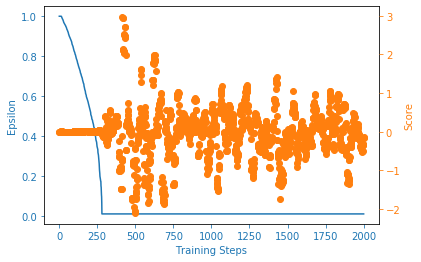

In [4]:
historical_data = pd.read_csv(r'C:\Users\ratatosck\Desktop\pythonScripts\TradeBot\HistoricalData\EURUSD15.csv', sep='\t',header=None)
historical_data.drop(0, axis=1, inplace = True)
historical_data_np = historical_data.to_numpy(dtype = 'float32')

### hyperparameters
observation_size = 30

env = environment(historical_data_np, observation_size)

agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size=64, n_actions = 3, 
             eps_end = 0.01, input_dims1 = [observation_size, 5], input_dims2 = [2], lr=0.003)

###
scores, eps_history = [], []
n_games = 2000

for i in range (n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])

    print('episode', i, 'score %.2f' % score, 
             'average score %.2f' % avg_score,
             'epsilon %.2f'% agent.epsilon)
        
x = [i+1 for i in range(n_games)]
filename = 'results-v1'
plot_learning_curve(x, scores, eps_history, filename)